# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
#from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en matlab


In [2]:
import scipy.io as sio
import hdf5storage
datos_matlab = hdf5storage.loadmat('../datos_octubre_2018/conjunto_entrenamiento_octubre_2018_red_pitch5mm_rad161mm_total.mat')
conjunto_datos= datos_matlab.get('photodefA')
conjunto_datos.shape

(66498, 640)

In [3]:
import os
import pandas as pd
dir_name='../datos_octubre_2018'
base_filename='p_OF_5mm_161mm'
filename_suffix='.h5'
file=os.path.join(dir_name, base_filename+ "{0:03d}".format(0) + filename_suffix)
conjunto_datos_waves=pd.read_hdf(file,'MC')
datos_waves=conjunto_datos_waves.values
datos_waves.shape

(6320, 3840)

In [4]:
for i in range(1,2):
    file=os.path.join(dir_name, base_filename+ "{0:03d}".format(i) + filename_suffix)
    #print(file)
    veamos=pd.read_hdf(file,'MC')
    veamos_array=veamos.values
    datos_waves=np.concatenate((datos_waves,veamos_array),axis=0)
datos_waves.shape

(12641, 3840)

In [5]:
L1A=6;
# hay tres L1 con 640 sensores (40*16)
# input image dimensions
img_rows, img_cols = 16, 40

X_trained=datos_waves;
x_trained=X_trained;

for i in range (X_trained.shape[0]):
    idea1=X_trained[i,:].reshape(img_rows,(L1A*img_cols));
    ideat=idea1.transpose();
    idea2=ideat.reshape(1,(L1A*img_cols)*img_rows);
    x_trained[i,:] =idea2;

print(x_trained.shape)


(12641, 3840)


In [6]:
input_output_dim_A=img_rows*img_cols
ideaA=np.zeros((L1A,input_output_dim_A))

conjunto_datos=np.zeros((x_trained.shape[0]*L1A,input_output_dim_A))
for i in range(x_trained.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_trained[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    conjunto_datos[(i)*L1A :(i+1)*L1A,:] = ideaA    
    

  

## Network parameters:

In [7]:
use_regularizer = True
my_regularizer = None
my_epochs = 50
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l2(0.001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

   
    
encoding_dim = 320  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_img = Input(shape=(img_rows*img_cols,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh', use_bias=False,bias_initializer='random_uniform')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(img_cols*img_rows, activation='tanh',use_bias=True,bias_initializer='random_uniform')(encoded)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoder = Model(input_img, decoded)

## Prepare data into training and test set.

In [8]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=60
val_size=20
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]





Y_train=conjunto_datos[:tamanyo_tr,1] #elijo la coordenada radius
Y_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

75846
conjunto_datos shape: (75846, 640)
45507
15169
15170


In [9]:
X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows,1)
X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows,1)


input_shape = (img_cols, img_rows,1)
#input_shape=input_shape.astype('int32')

In [10]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (45507, 40, 16, 1)
45507 train samples
15169 validation samples
15170 test samples


Display 20 random training images using image

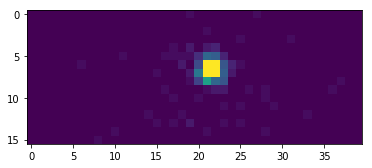

26884


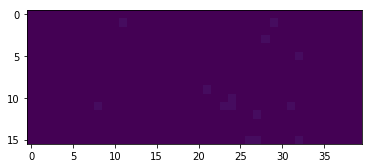

29704


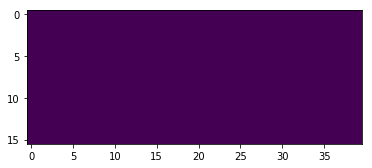

2162


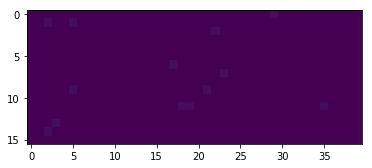

28469


In [11]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [16, 40]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [12]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
prueba=x_train[0:15170,:]
print(x_train.shape)
print(x_test.shape)
print(prueba.shape)

(45507, 640)
(15170, 640)
(15170, 640)


In [13]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=100
print(min_max_scaler)
#x_train_scaled = min_max_scaler.transform(x_train)
#x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=(x_train/supermax)
x_test_scaled=(x_test/supermax)
#min_max_scaler.scale_
x_train[29413]
x_train_scaled[29413]

MinMaxScaler(copy=True, feature_range=(0, 1))


array([0.01, 0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.03, 0.  , 0.04, 0.02,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02,
       0.03, 0.04, 0.01, 0.  , 0.02, 0.01, 0.02, 0.01, 0.02, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.02, 0.  , 0.04, 0.05, 0.04, 0.01, 0.  , 0.  ,
       0.01, 0.01, 0.02, 0.01, 0.  , 0.  , 0.01, 0.  , 0.01, 0.02, 0.03,
       0.02, 0.01, 0.  , 0.04, 0.04, 0.04, 0.  , 0.01, 0.01, 0.01, 0.  ,
       0.01, 0.  , 0.01, 0.03, 0.01, 0.01, 0.02, 0.01, 0.02, 0.03, 0.01,
       0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.02, 0.02, 0.01,
       0.03, 0.04, 0.03, 0.03, 0.01, 0.03, 0.  , 0.02, 0.  , 0.  , 0.01,
       0.  , 0.  , 0.02, 0.01, 0.02, 0.01, 0.02, 0.  , 0.03, 0.02, 0.01,
       0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.03, 0.02,
       0.01, 0.  , 0.01, 0.03, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01,
       0.02, 0.  , 0.  , 0.01, 0.04, 0.02, 0.  , 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.

## Build the autoencoder. 

In [14]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='RMSprop', loss='mse')



Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [15]:
algoritmo='rmsprop'
experimento="scaled_100_encoder_without_bias_tanh"
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/{}{}{}".format(algoritmo,experimento,time()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=2, mode='auto', baseline=None)
autoencoder.fit(x_train_scaled, x_train_scaled,
                epochs=10000,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop],
                validation_data=(x_test_scaled, x_test_scaled))



Train on 45507 samples, validate on 15170 samples
Epoch 1/10000
45507/45507 [==============================] - 2s 34us/step - loss: 0.1593 - val_loss: 0.1149
Epoch 2/10000
45507/45507 [==============================] - 1s 32us/step - loss: 0.0927 - val_loss: 0.0749
Epoch 3/10000
45507/45507 [==============================] - 2s 36us/step - loss: 0.0629 - val_loss: 0.0524
Epoch 4/10000
45507/45507 [==============================] - 2s 36us/step - loss: 0.0442 - val_loss: 0.0370
Epoch 5/10000
45507/45507 [==============================] - 2s 33us/step - loss: 0.0312 - val_loss: 0.0261
Epoch 6/10000
45507/45507 [==============================] - 2s 36us/step - loss: 0.0219 - val_loss: 0.0182
Epoch 7/10000
45507/45507 [==============================] - 2s 35us/step - loss: 0.0153 - val_loss: 0.0126
Epoch 8/10000
45507/45507 [==============================] - 2s 35us/step - loss: 0.0106 - val_loss: 0.0087
Epoch 9/10000
45507/45507 [==============================] - 2s 35us/step - loss: 0.00

45507/45507 [==============================] - 2s 36us/step - loss: 3.4299e-04 - val_loss: 3.0066e-04
Epoch 72/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4296e-04 - val_loss: 3.0063e-04
Epoch 73/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4292e-04 - val_loss: 3.0060e-04
Epoch 74/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4289e-04 - val_loss: 3.0056e-04
Epoch 75/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4286e-04 - val_loss: 3.0053e-04
Epoch 76/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4283e-04 - val_loss: 3.0050e-04
Epoch 77/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4280e-04 - val_loss: 3.0047e-04
Epoch 78/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4277e-04 - val_loss: 3.0044e-04
Epoch 79/10000
45507/45507 [==============================] - 2s 36us/step - lo

Epoch 141/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4198e-04 - val_loss: 2.9966e-04
Epoch 142/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4198e-04 - val_loss: 2.9966e-04
Epoch 143/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4197e-04 - val_loss: 2.9965e-04
Epoch 144/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4197e-04 - val_loss: 2.9965e-04
Epoch 145/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4196e-04 - val_loss: 2.9964e-04
Epoch 146/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4196e-04 - val_loss: 2.9964e-04
Epoch 147/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4195e-04 - val_loss: 2.9963e-04
Epoch 148/10000
45507/45507 [==============================] - 1s 29us/step - loss: 3.4195e-04 - val_loss: 2.9963e-04
Epoch 149/10000
45507/45507 [===========================

45507/45507 [==============================] - 2s 36us/step - loss: 3.4174e-04 - val_loss: 2.9942e-04
Epoch 211/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4174e-04 - val_loss: 2.9942e-04
Epoch 212/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4174e-04 - val_loss: 2.9942e-04
Epoch 213/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4173e-04 - val_loss: 2.9941e-04
Epoch 214/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4173e-04 - val_loss: 2.9941e-04
Epoch 215/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4173e-04 - val_loss: 2.9941e-04
Epoch 216/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4173e-04 - val_loss: 2.9941e-04
Epoch 217/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4173e-04 - val_loss: 2.9941e-04
Epoch 218/10000
45507/45507 [==============================] - 2s 35us/s

45507/45507 [==============================] - 1s 27us/step - loss: 3.4163e-04 - val_loss: 2.9931e-04
Epoch 280/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4163e-04 - val_loss: 2.9931e-04
Epoch 281/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4163e-04 - val_loss: 2.9931e-04
Epoch 282/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4163e-04 - val_loss: 2.9931e-04
Epoch 283/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4163e-04 - val_loss: 2.9931e-04
Epoch 284/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4163e-04 - val_loss: 2.9931e-04
Epoch 285/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4163e-04 - val_loss: 2.9931e-04
Epoch 286/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4162e-04 - val_loss: 2.9930e-04
Epoch 287/10000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 36us/step - loss: 3.4157e-04 - val_loss: 2.9925e-04
Epoch 349/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4157e-04 - val_loss: 2.9925e-04
Epoch 350/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4157e-04 - val_loss: 2.9925e-04
Epoch 351/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4157e-04 - val_loss: 2.9925e-04
Epoch 352/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4157e-04 - val_loss: 2.9925e-04
Epoch 353/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4157e-04 - val_loss: 2.9925e-04
Epoch 354/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4157e-04 - val_loss: 2.9925e-04
Epoch 355/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4157e-04 - val_loss: 2.9925e-04
Epoch 356/10000
45507/45507 [==============================] - 1s 30us/s

45507/45507 [==============================] - 2s 37us/step - loss: 3.4153e-04 - val_loss: 2.9921e-04
Epoch 418/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4153e-04 - val_loss: 2.9921e-04
Epoch 419/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4153e-04 - val_loss: 2.9921e-04
Epoch 420/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4153e-04 - val_loss: 2.9921e-04
Epoch 421/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4153e-04 - val_loss: 2.9921e-04
Epoch 422/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4153e-04 - val_loss: 2.9921e-04
Epoch 423/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4153e-04 - val_loss: 2.9921e-04
Epoch 424/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4153e-04 - val_loss: 2.9921e-04
Epoch 425/10000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 36us/step - loss: 3.4150e-04 - val_loss: 2.9918e-04
Epoch 487/10000
45507/45507 [==============================] - 1s 30us/step - loss: 3.4150e-04 - val_loss: 2.9918e-04
Epoch 488/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4150e-04 - val_loss: 2.9918e-04
Epoch 489/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4150e-04 - val_loss: 2.9918e-04
Epoch 490/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4150e-04 - val_loss: 2.9918e-04
Epoch 491/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4150e-04 - val_loss: 2.9918e-04
Epoch 492/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4150e-04 - val_loss: 2.9918e-04
Epoch 493/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4150e-04 - val_loss: 2.9918e-04
Epoch 494/10000
45507/45507 [==============================] - 2s 33us/s

45507/45507 [==============================] - 2s 35us/step - loss: 3.4148e-04 - val_loss: 2.9916e-04
Epoch 556/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4148e-04 - val_loss: 2.9916e-04
Epoch 557/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4148e-04 - val_loss: 2.9916e-04
Epoch 558/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4148e-04 - val_loss: 2.9916e-04
Epoch 559/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4148e-04 - val_loss: 2.9916e-04
Epoch 560/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4148e-04 - val_loss: 2.9916e-04
Epoch 561/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4148e-04 - val_loss: 2.9916e-04
Epoch 562/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4148e-04 - val_loss: 2.9916e-04
Epoch 563/10000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 34us/step - loss: 3.4147e-04 - val_loss: 2.9915e-04
Epoch 625/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4147e-04 - val_loss: 2.9915e-04
Epoch 626/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4147e-04 - val_loss: 2.9915e-04
Epoch 627/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4147e-04 - val_loss: 2.9915e-04
Epoch 628/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4147e-04 - val_loss: 2.9915e-04
Epoch 629/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4147e-04 - val_loss: 2.9915e-04
Epoch 630/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4147e-04 - val_loss: 2.9914e-04
Epoch 631/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4147e-04 - val_loss: 2.9914e-04
Epoch 632/10000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 1s 32us/step - loss: 3.4145e-04 - val_loss: 2.9913e-04
Epoch 694/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4145e-04 - val_loss: 2.9913e-04
Epoch 695/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4145e-04 - val_loss: 2.9913e-04
Epoch 696/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4145e-04 - val_loss: 2.9913e-04
Epoch 697/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4145e-04 - val_loss: 2.9913e-04
Epoch 698/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4145e-04 - val_loss: 2.9913e-04
Epoch 699/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4145e-04 - val_loss: 2.9913e-04
Epoch 700/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4145e-04 - val_loss: 2.9913e-04
Epoch 701/10000
45507/45507 [==============================] - 1s 31us/s

45507/45507 [==============================] - 2s 34us/step - loss: 3.4144e-04 - val_loss: 2.9912e-04
Epoch 763/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4144e-04 - val_loss: 2.9912e-04
Epoch 764/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4144e-04 - val_loss: 2.9912e-04
Epoch 765/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4144e-04 - val_loss: 2.9912e-04
Epoch 766/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4144e-04 - val_loss: 2.9912e-04
Epoch 767/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4144e-04 - val_loss: 2.9912e-04
Epoch 768/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4144e-04 - val_loss: 2.9912e-04
Epoch 769/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4144e-04 - val_loss: 2.9912e-04
Epoch 770/10000
45507/45507 [==============================] - 1s 28us/s

45507/45507 [==============================] - 2s 36us/step - loss: 3.4144e-04 - val_loss: 2.9912e-04
Epoch 832/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4144e-04 - val_loss: 2.9912e-04
Epoch 833/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4144e-04 - val_loss: 2.9912e-04
Epoch 834/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4144e-04 - val_loss: 2.9911e-04
Epoch 835/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4144e-04 - val_loss: 2.9911e-04
Epoch 836/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4144e-04 - val_loss: 2.9911e-04
Epoch 837/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4144e-04 - val_loss: 2.9911e-04
Epoch 838/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4144e-04 - val_loss: 2.9911e-04
Epoch 839/10000
45507/45507 [==============================] - 2s 34us/s

45507/45507 [==============================] - 2s 36us/step - loss: 3.4143e-04 - val_loss: 2.9911e-04
Epoch 901/10000
45507/45507 [==============================] - 1s 29us/step - loss: 3.4143e-04 - val_loss: 2.9911e-04
Epoch 902/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4143e-04 - val_loss: 2.9911e-04
Epoch 903/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4143e-04 - val_loss: 2.9911e-04
Epoch 904/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4143e-04 - val_loss: 2.9911e-04
Epoch 905/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4143e-04 - val_loss: 2.9911e-04
Epoch 906/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4143e-04 - val_loss: 2.9911e-04
Epoch 907/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4143e-04 - val_loss: 2.9911e-04
Epoch 908/10000
45507/45507 [==============================] - 2s 34us/s

45507/45507 [==============================] - 2s 37us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 970/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 971/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 972/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 973/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 974/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 975/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 976/10000
45507/45507 [==============================] - 1s 30us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 977/10000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 37us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 1039/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 1040/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 1041/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 1042/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 1043/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 1044/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 1045/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4142e-04 - val_loss: 2.9910e-04
Epoch 1046/10000
45507/45507 [==============================] - 2

Epoch 1107/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1108/10000
45507/45507 [==============================] - 1s 27us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1109/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1110/10000
45507/45507 [==============================] - 1s 24us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1111/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1112/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1113/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1114/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1115/10000
45507/45507 [==================

Epoch 1176/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1177/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1178/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1179/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1180/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1181/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1182/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1183/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1184/10000
45507/45507 [==================

Epoch 1245/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1246/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4141e-04 - val_loss: 2.9909e-04
Epoch 1247/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4141e-04 - val_loss: 2.9908e-04
Epoch 1248/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4141e-04 - val_loss: 2.9908e-04
Epoch 1249/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4141e-04 - val_loss: 2.9908e-04
Epoch 1250/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4141e-04 - val_loss: 2.9908e-04
Epoch 1251/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4141e-04 - val_loss: 2.9908e-04
Epoch 1252/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4141e-04 - val_loss: 2.9908e-04
Epoch 1253/10000
45507/45507 [==================

Epoch 1314/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1315/10000
45507/45507 [==============================] - 1s 28us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1316/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1317/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1318/10000
45507/45507 [==============================] - 1s 30us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1319/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1320/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1321/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1322/10000
45507/45507 [==================

Epoch 1383/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1384/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1385/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1386/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1387/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1388/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1389/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1390/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1391/10000
45507/45507 [==================

Epoch 1452/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1453/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1454/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1455/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1456/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1457/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1458/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1459/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4140e-04 - val_loss: 2.9908e-04
Epoch 1460/10000
45507/45507 [==================

Epoch 1521/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4140e-04 - val_loss: 2.9907e-04
Epoch 1522/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4140e-04 - val_loss: 2.9907e-04
Epoch 1523/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4140e-04 - val_loss: 2.9907e-04
Epoch 1524/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4140e-04 - val_loss: 2.9907e-04
Epoch 1525/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1526/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1527/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1528/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1529/10000
45507/45507 [==================

Epoch 1590/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1591/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1592/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1593/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1594/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1595/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1596/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1597/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1598/10000
45507/45507 [==================

Epoch 1659/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1660/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1661/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1662/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1663/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1664/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1665/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1666/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1667/10000
45507/45507 [==================

Epoch 1728/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1729/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1730/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1731/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1732/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1733/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1734/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1735/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1736/10000
45507/45507 [==================

Epoch 1797/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1798/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1799/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1800/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1801/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1802/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1803/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1804/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1805/10000
45507/45507 [==================

Epoch 1866/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1867/10000
45507/45507 [==============================] - 1s 27us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1868/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1869/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1870/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1871/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1872/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1873/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1874/10000
45507/45507 [==================

Epoch 1935/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1936/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1937/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1938/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1939/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1940/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4139e-04 - val_loss: 2.9907e-04
Epoch 1941/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4139e-04 - val_loss: 2.9906e-04
Epoch 1942/10000
45507/45507 [==============================] - 1s 29us/step - loss: 3.4139e-04 - val_loss: 2.9906e-04
Epoch 1943/10000
45507/45507 [==================

Epoch 2004/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2005/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2006/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2007/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2008/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2009/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2010/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2011/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2012/10000
45507/45507 [==================

Epoch 2073/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2074/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2075/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2076/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2077/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2078/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2079/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2080/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2081/10000
45507/45507 [==================

Epoch 2142/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2143/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2144/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2145/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2146/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2147/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2148/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2149/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2150/10000
45507/45507 [==================

Epoch 2211/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2212/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2213/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2214/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2215/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2216/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2217/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2218/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2219/10000
45507/45507 [==================

Epoch 2280/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2281/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2282/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2283/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2284/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2285/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2286/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2287/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2288/10000
45507/45507 [==================

Epoch 2349/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2350/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2351/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2352/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2353/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2354/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2355/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2356/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2357/10000
45507/45507 [==================

Epoch 2418/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2419/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2420/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2421/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2422/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2423/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2424/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2425/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2426/10000
45507/45507 [==================

Epoch 2487/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2488/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2489/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2490/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2491/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2492/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2493/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2494/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2495/10000
45507/45507 [==================

45507/45507 [==============================] - 2s 35us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2556/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2557/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2558/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2559/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2560/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2561/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2562/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2563/10000
45507/45507 [==============================] - 2

Epoch 2624/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2625/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2626/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2627/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2628/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2629/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2630/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2631/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4138e-04 - val_loss: 2.9906e-04
Epoch 2632/10000
45507/45507 [==================

Epoch 2693/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9905e-04
Epoch 2694/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9905e-04
Epoch 2695/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4138e-04 - val_loss: 2.9905e-04
Epoch 2696/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4138e-04 - val_loss: 2.9905e-04
Epoch 2697/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4138e-04 - val_loss: 2.9905e-04
Epoch 2698/10000
45507/45507 [==============================] - 1s 24us/step - loss: 3.4138e-04 - val_loss: 2.9905e-04
Epoch 2699/10000
45507/45507 [==============================] - 1s 30us/step - loss: 3.4138e-04 - val_loss: 2.9905e-04
Epoch 2700/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4138e-04 - val_loss: 2.9905e-04
Epoch 2701/10000
45507/45507 [==================

Epoch 2762/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2763/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2764/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2765/10000
45507/45507 [==============================] - 1s 30us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2766/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2767/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2768/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2769/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2770/10000
45507/45507 [==================

Epoch 2831/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2832/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2833/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2834/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2835/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2836/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2837/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2838/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2839/10000
45507/45507 [==================

Epoch 2900/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2901/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2902/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2903/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2904/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2905/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2906/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2907/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2908/10000
45507/45507 [==================

Epoch 2969/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2970/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2971/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2972/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2973/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2974/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2975/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2976/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 2977/10000
45507/45507 [==================

Epoch 3038/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3039/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3040/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3041/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3042/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3043/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3044/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3045/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3046/10000
45507/45507 [==================

Epoch 3107/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3108/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3109/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3110/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3111/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3112/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3113/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3114/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3115/10000
45507/45507 [==================

Epoch 3176/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3177/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3178/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3179/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3180/10000
45507/45507 [==============================] - 1s 28us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3181/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3182/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3183/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3184/10000
45507/45507 [==================

Epoch 3245/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3246/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3247/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3248/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3249/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3250/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3251/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3252/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3253/10000
45507/45507 [==================

Epoch 3314/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3315/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3316/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3317/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3318/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3319/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3320/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3321/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3322/10000
45507/45507 [==================

Epoch 3383/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3384/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3385/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3386/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3387/10000
45507/45507 [==============================] - 1s 26us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3388/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3389/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3390/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3391/10000
45507/45507 [==================

Epoch 3452/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3453/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3454/10000
45507/45507 [==============================] - 1s 22us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3455/10000
45507/45507 [==============================] - 1s 28us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3456/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3457/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3458/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3459/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3460/10000
45507/45507 [==================

Epoch 3521/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3522/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3523/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3524/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3525/10000
45507/45507 [==============================] - 1s 30us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3526/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3527/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3528/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3529/10000
45507/45507 [==================

Epoch 3590/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3591/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3592/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3593/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3594/10000
45507/45507 [==============================] - 1s 29us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3595/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3596/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3597/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3598/10000
45507/45507 [==================

Epoch 3659/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3660/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9905e-04
Epoch 3661/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3662/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3663/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3664/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3665/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3666/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3667/10000
45507/45507 [==================

Epoch 3728/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3729/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3730/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3731/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3732/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3733/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3734/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3735/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3736/10000
45507/45507 [==================

Epoch 3797/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3798/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3799/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4137e-04 - val_loss: 2.9904e-04
Epoch 3800/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3801/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3802/10000
45507/45507 [==============================] - 1s 30us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3803/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3804/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3805/10000
45507/45507 [==================

Epoch 3866/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3867/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3868/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3869/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3870/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3871/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3872/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3873/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3874/10000
45507/45507 [==================

Epoch 3935/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3936/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3937/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3938/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3939/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3940/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3941/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3942/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 3943/10000
45507/45507 [==================

Epoch 4004/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4005/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4006/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4007/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4008/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4009/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4010/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4011/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4012/10000
45507/45507 [==================

Epoch 4073/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4074/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4075/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4076/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4077/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4078/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4079/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4080/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4081/10000
45507/45507 [==================

Epoch 4142/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4143/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4144/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4145/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4146/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4147/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4148/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4149/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4150/10000
45507/45507 [==================

Epoch 4211/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4212/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4213/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4214/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4215/10000
45507/45507 [==============================] - 1s 30us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4216/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4217/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4218/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4219/10000
45507/45507 [==================

Epoch 4280/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4281/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4282/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4283/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4284/10000
45507/45507 [==============================] - 1s 24us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4285/10000
45507/45507 [==============================] - 1s 30us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4286/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4287/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4288/10000
45507/45507 [==================

Epoch 4349/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4350/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4351/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4352/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4353/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4354/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4355/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4356/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4357/10000
45507/45507 [==================

Epoch 4418/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4419/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4420/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4421/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4422/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4423/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4424/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4425/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4426/10000
45507/45507 [==================

Epoch 4487/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4488/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4489/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4490/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4491/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4492/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4493/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4494/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4495/10000
45507/45507 [==================

Epoch 4556/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4557/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4558/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4559/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4560/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4561/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4562/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4563/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4564/10000
45507/45507 [==================

Epoch 4625/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4626/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4627/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4628/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4629/10000
45507/45507 [==============================] - 1s 30us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4630/10000
45507/45507 [==============================] - 1s 30us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4631/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4632/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4633/10000
45507/45507 [==================

Epoch 4694/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4695/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4696/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4697/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4698/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4699/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4700/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4701/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4702/10000
45507/45507 [==================

Epoch 4763/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4764/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4765/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4766/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4767/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4768/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4769/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4770/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4771/10000
45507/45507 [==================

Epoch 4832/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4833/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4834/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4835/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4836/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4837/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4838/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4839/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4840/10000
45507/45507 [==================

Epoch 4901/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4902/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4903/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4904/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4905/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4906/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4907/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4908/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4909/10000
45507/45507 [==================

Epoch 4970/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4971/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4972/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4973/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4974/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4975/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4976/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4977/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 4978/10000
45507/45507 [==================

Epoch 5039/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5040/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5041/10000
45507/45507 [==============================] - 1s 26us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5042/10000
45507/45507 [==============================] - 1s 26us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5043/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5044/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5045/10000
45507/45507 [==============================] - 1s 30us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5046/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5047/10000
45507/45507 [==================

Epoch 5108/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5109/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5110/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5111/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5112/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5113/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5114/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5115/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5116/10000
45507/45507 [==================

Epoch 5177/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5178/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5179/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5180/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5181/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5182/10000
45507/45507 [==============================] - 1s 28us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5183/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5184/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5185/10000
45507/45507 [==================

Epoch 5246/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5247/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5248/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5249/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5250/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5251/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5252/10000
45507/45507 [==============================] - 1s 27us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5253/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5254/10000
45507/45507 [==================

Epoch 5315/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5316/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5317/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5318/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5319/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5320/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5321/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5322/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5323/10000
45507/45507 [==================

Epoch 5384/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5385/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5386/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5387/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5388/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5389/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5390/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5391/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5392/10000
45507/45507 [==================

Epoch 5453/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5454/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5455/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5456/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5457/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5458/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5459/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5460/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5461/10000
45507/45507 [==================

Epoch 5522/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5523/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5524/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5525/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5526/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5527/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5528/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5529/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5530/10000
45507/45507 [==================

Epoch 5591/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5592/10000
45507/45507 [==============================] - 1s 26us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5593/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5594/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5595/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5596/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5597/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5598/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5599/10000
45507/45507 [==================

Epoch 5660/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5661/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5662/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5663/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5664/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5665/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5666/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5667/10000
45507/45507 [==============================] - 1s 28us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5668/10000
45507/45507 [==================

Epoch 5729/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5730/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5731/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5732/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5733/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5734/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5735/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5736/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5737/10000
45507/45507 [==================

Epoch 5798/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5799/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5800/10000
45507/45507 [==============================] - 1s 21us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5801/10000
45507/45507 [==============================] - 1s 29us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5802/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5803/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5804/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5805/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5806/10000
45507/45507 [==================

Epoch 5867/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5868/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5869/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5870/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5871/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5872/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5873/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5874/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5875/10000
45507/45507 [==================

45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5936/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5937/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5938/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5939/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5940/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5941/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5942/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 5943/10000
45507/45507 [==============================] - 2

Epoch 6004/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6005/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6006/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6007/10000
45507/45507 [==============================] - 1s 27us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6008/10000
45507/45507 [==============================] - 1s 29us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6009/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6010/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6011/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6012/10000
45507/45507 [==================

Epoch 6073/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6074/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6075/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6076/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6077/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6078/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6079/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6080/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6081/10000
45507/45507 [==================

Epoch 6142/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6143/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6144/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6145/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6146/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6147/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6148/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6149/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6150/10000
45507/45507 [==================

45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6211/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6212/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6213/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6214/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6215/10000
45507/45507 [==============================] - 1s 29us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6216/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6217/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6218/10000
45507/45507 [==============================] - 2

Epoch 6279/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6280/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6281/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6282/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6283/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6284/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6285/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6286/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6287/10000
45507/45507 [==================

Epoch 6348/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6349/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6350/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6351/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6352/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6353/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6354/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6355/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6356/10000
45507/45507 [==================

Epoch 6417/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6418/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6419/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6420/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6421/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6422/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6423/10000
45507/45507 [==============================] - 1s 30us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6424/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6425/10000
45507/45507 [==================

Epoch 6486/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6487/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6488/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6489/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6490/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6491/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6492/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6493/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6494/10000
45507/45507 [==================

Epoch 6555/10000
45507/45507 [==============================] - 1s 27us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6556/10000
45507/45507 [==============================] - 1s 29us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6557/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6558/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6559/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6560/10000
45507/45507 [==============================] - 1s 24us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6561/10000
45507/45507 [==============================] - 1s 29us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6562/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6563/10000
45507/45507 [==================

Epoch 6624/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6625/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6626/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6627/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6628/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6629/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6630/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6631/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6632/10000
45507/45507 [==================

Epoch 6693/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6694/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6695/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6696/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6697/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6698/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6699/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6700/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6701/10000
45507/45507 [==================

Epoch 6762/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6763/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6764/10000
45507/45507 [==============================] - 1s 27us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6765/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6766/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6767/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6768/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6769/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6770/10000
45507/45507 [==================

Epoch 6831/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6832/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6833/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6834/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6835/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6836/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6837/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6838/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6839/10000
45507/45507 [==================

Epoch 6900/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6901/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6902/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6903/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6904/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6905/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6906/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6907/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6908/10000
45507/45507 [==================

Epoch 6969/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6970/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6971/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6972/10000
45507/45507 [==============================] - 1s 29us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6973/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6974/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6975/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6976/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 6977/10000
45507/45507 [==================

Epoch 7038/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7039/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7040/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7041/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7042/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7043/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7044/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7045/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7046/10000
45507/45507 [==================

Epoch 7107/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7108/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7109/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7110/10000
45507/45507 [==============================] - 1s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7111/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7112/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7113/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7114/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7115/10000
45507/45507 [==================

Epoch 7176/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7177/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7178/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7179/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7180/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7181/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7182/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7183/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7184/10000
45507/45507 [==================

Epoch 7245/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7246/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7247/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7248/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7249/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7250/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7251/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7252/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7253/10000
45507/45507 [==================

Epoch 7314/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7315/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7316/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7317/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7318/10000
45507/45507 [==============================] - 1s 23us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7319/10000
45507/45507 [==============================] - 1s 22us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7320/10000
45507/45507 [==============================] - 1s 26us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7321/10000
45507/45507 [==============================] - 2s 33us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7322/10000
45507/45507 [==================

45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7383/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7384/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7385/10000
45507/45507 [==============================] - 1s 31us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7386/10000
45507/45507 [==============================] - 1s 32us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7387/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7388/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7389/10000
45507/45507 [==============================] - 2s 34us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7390/10000
45507/45507 [==============================] - 2

Epoch 7451/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7452/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7453/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7454/10000
45507/45507 [==============================] - 2s 35us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7455/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7456/10000
45507/45507 [==============================] - 2s 37us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7457/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7458/10000
45507/45507 [==============================] - 2s 36us/step - loss: 3.4136e-04 - val_loss: 2.9904e-04
Epoch 7459/10000
45507/45507 [==================

In [16]:
autoencoder.evaluate(x=x_test_scaled,y=x_test_scaled)

15170/15170 [==============================] - 1s 71us/step


0.00029904000600554587

In [17]:
autoencoder.save_weights('../redes_compresoras/compresor_python_{}{}{}'.format(algoritmo,experimento,time()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)

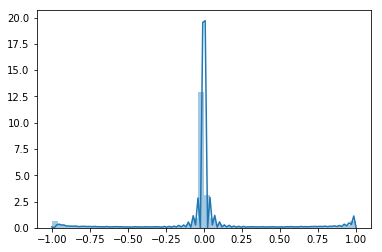

In [18]:
standard_scores = encoder.predict(x_test_scaled).ravel()
#regularized_scores = encoded_regularized.predict(x_test).ravel()
sns.distplot(standard_scores, hist=True, label='standard model')
#sns.distplot(regularized_scores, hist=False, label='regularized model')

In [19]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
#decoded_imgs_scaled = autoencoder.predict(x_test_min_max)
decoded_imgs_scaled = autoencoder.predict(x_test_scaled)
decoded_imgs = supermax*decoded_imgs_scaled
#decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


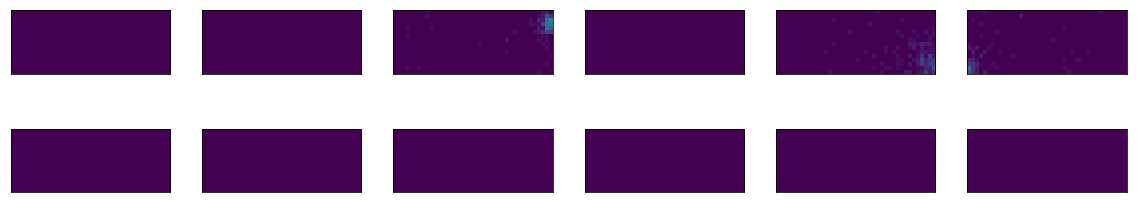

12373


In [20]:
n = 6  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(40, 16).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(40, 16).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)



In [21]:
import pandas as pd
filename = '../datos_octubre_2018/p_OF_5mm_161mm003.h5'
conjunto_datos_test=pd.read_hdf(filename,'MC');
conjunto_datos_test.shape

(6296, 3840)

In [22]:
L1A=6;
# hay tres L1 con 640 sensores (40*16)
L1B=0;
# hay dos L1 con 640 sensores (40*16)
X_trained=conjunto_datos_test.values;
x_trained=X_trained;

for i in range (X_trained.shape[0]):
    idea1=X_trained[i,:].reshape(img_rows,(L1A*img_cols));
    ideat=idea1.transpose();
    idea2=ideat.reshape(1,(L1A*img_cols)*img_rows);
    x_trained[i,:] =idea2;
x_tested = x_trained;
print(x_trained.shape)
print(x_tested.shape)

(6296, 3840)
(6296, 3840)


# Vamos a procesar y comprimir con la red

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 5 veces

In [23]:

def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))

cara_externa=x_tested[:,0: L1A*input_output_dim_A] 
cara_externa_reconstruida=np.zeros((x_tested.shape[0],L1A*input_output_dim_A))
for i in range(x_tested.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_tested[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    #ideaA_scaled=min_max_scaler.transform(ideaA)
    ideaA_scaled=ideaA/(supermax)
    salida_reconstructed_1_scaled = autoencoder.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*salida_reconstructed_1_scaled
    #salida_reconstructed_1 = min_max_scaler.inverse_transform(salida_reconstructed_1_scaled)     
    #salida_reconstructed_1 = ideaA
    
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
    #entrada_imgs_A=(ideaA) #he quitado el escalado
    #encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
    #decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
    #print(decoded_imgs_A.shape)
    #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
    #salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    
 
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))

    #print(hola.shape)
    salida_total=hola1
    #salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
  

## Visualizamos los resultados

Visualizamos todos los sensores: 

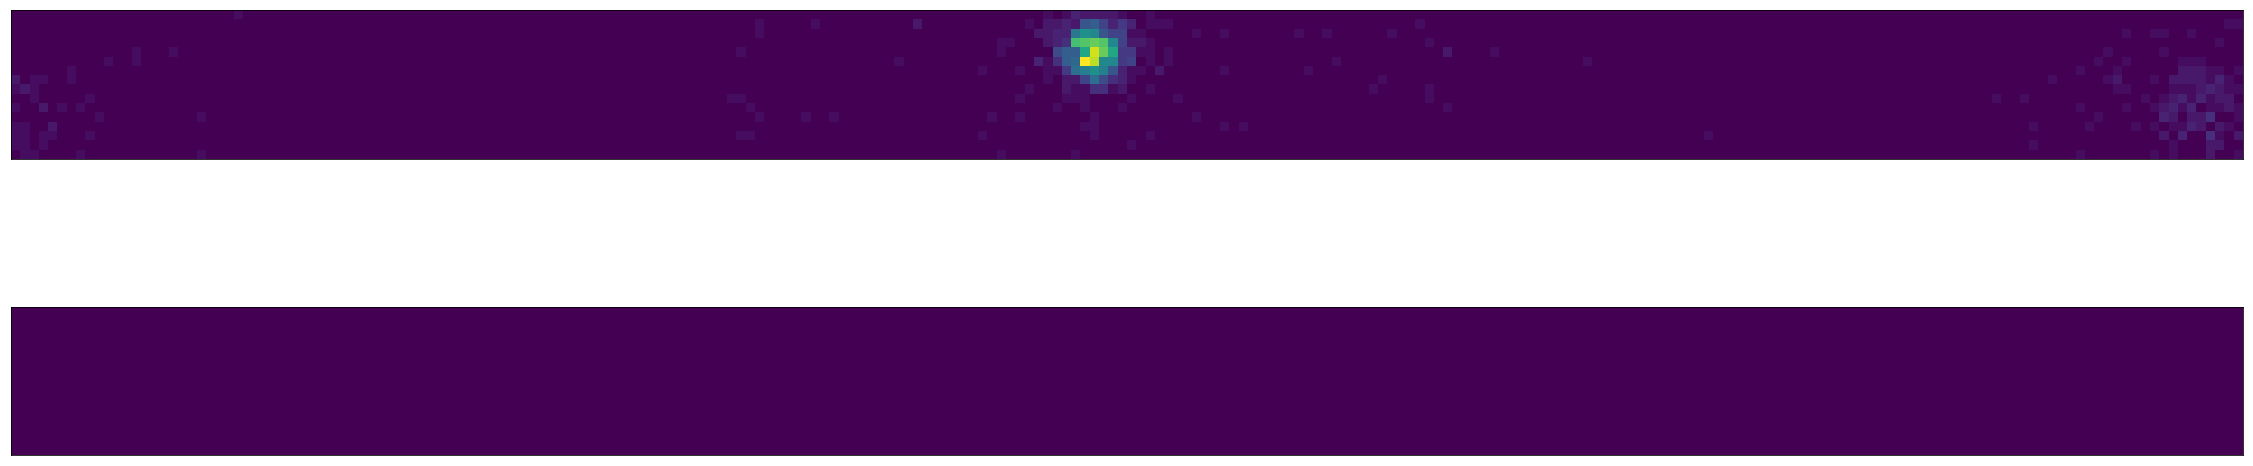

In [24]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_tested.shape[0])
    idea=1890
    idea= 4299
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_cols, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_cols, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Visualizamos ahora L1 a L1, teniendo en cuenta que hay de dos tipos:
L1A (con 36 columnas )

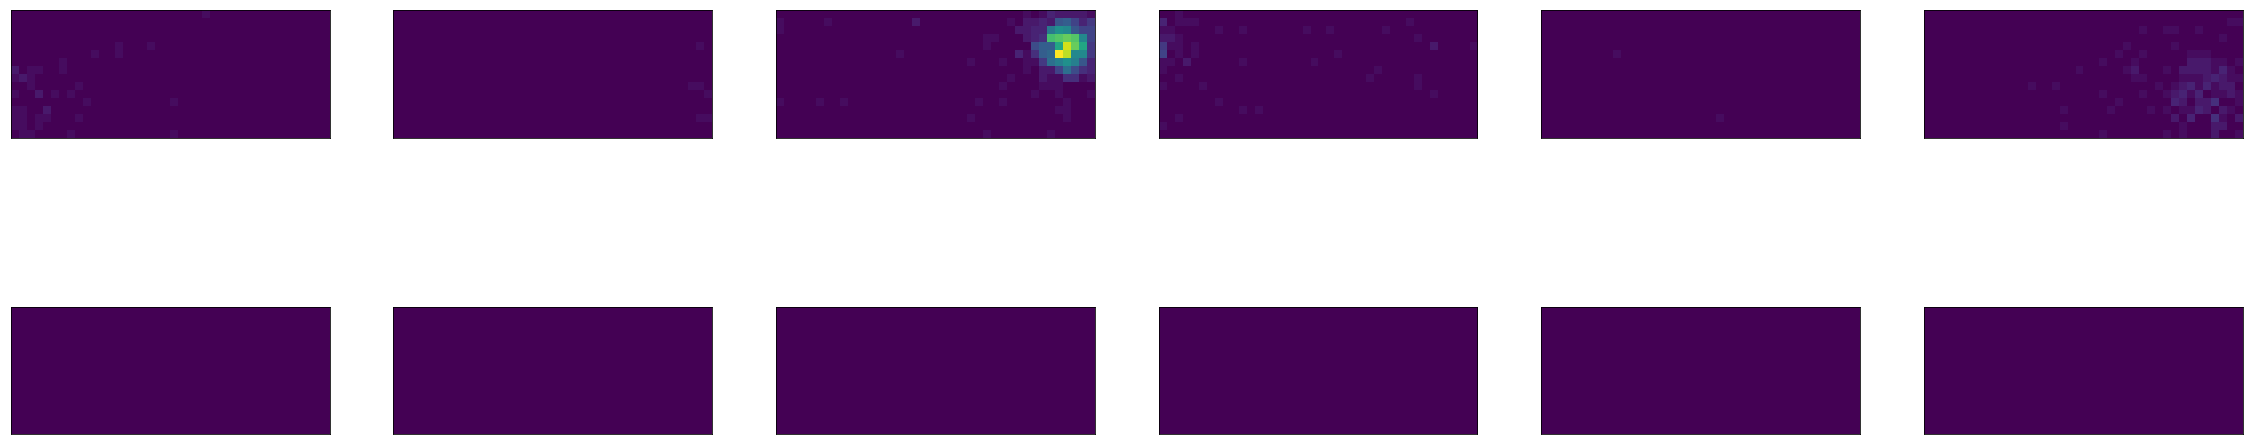

In [25]:
n = L1A  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_cols, img_rows).transpose()[:,i*img_cols:(i+1)*img_cols] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_cols, img_rows).transpose()[:,i*img_cols:(i+1)*img_cols] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [26]:
i=2
print(cara_externa[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:])
print(np.sum(cara_externa[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:]))

[[ 0  1  1  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0

In [27]:
print(cara_externa_reconstruida[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:].astype(int))
print(np.sum(cara_externa_reconstruida[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:]))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 

In [28]:
print(idea)

4299
